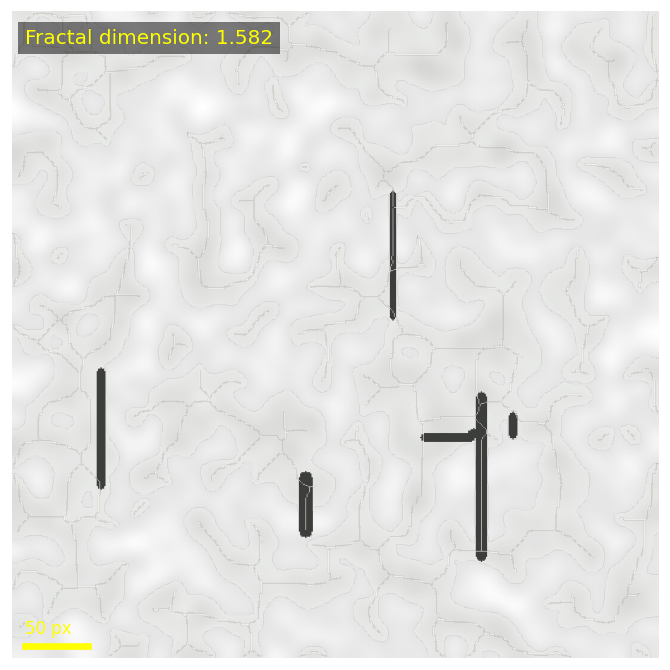

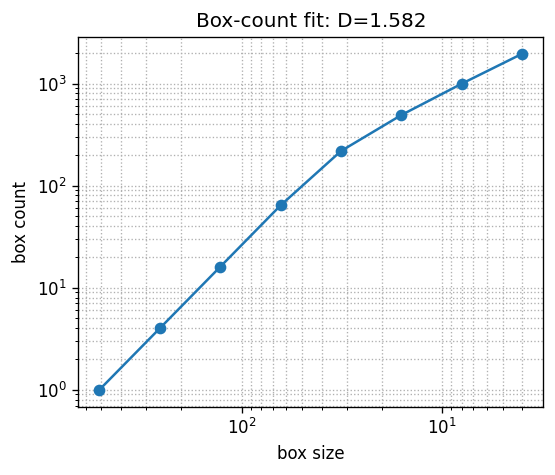

Estimated fractal dimension: 1.5824138834848458


In [5]:
# Fractal annotated fracture analysis (all-in-one Jupyter cell, NumPy 2.x compatible)

# Uncomment if needed:
# !pip install scikit-image opencv-python matplotlib numpy scipy

import os, math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, util
from skimage.transform import resize
from scipy import ndimage as ndi
import cv2

plt.rcParams["figure.dpi"] = 120

# --- Synthetic fracture generator (optional) ---
def generate_synthetic_fracture(shape=(512,512), n_cracks=6, max_length=400, thickness_range=(1,6), seed=None):
    rng = np.random.default_rng(seed)
    img = np.zeros(shape, dtype=np.float32)
    h, w = shape
    for _ in range(n_cracks):
        length = int(rng.integers(max_length//4, max_length))
        x, y = rng.integers(0, w), rng.integers(0, h)
        angle = rng.random() * 2*np.pi
        thickness = rng.integers(thickness_range[0], thickness_range[1])
        pts = []
        for _ in range(length):
            x += int(math.cos(angle) * (1 + 0.2*rng.standard_normal()))
            y += int(math.sin(angle) * (1 + 0.2*rng.standard_normal()))
            if x < 0 or x >= w or y < 0 or y >= h: break
            pts.append((x,y)); angle += 0.02 * rng.standard_normal()
        for p in pts: cv2.circle(img, p, int(thickness), 1.0, -1)
    noise = ndi.gaussian_filter(rng.standard_normal(shape), sigma=8)
    noise = (noise - noise.min())/(np.ptp(noise)+1e-9)   # fixed for NumPy 2.x
    img = np.clip(img + 0.2*noise, 0, 1)
    return ((1.0 - img) * 255).astype(np.uint8)

# --- Processing functions ---
def preprocess(img, sigma=1.0):
    imgf = img.astype(np.float32)/255.0
    p2, p98 = np.percentile(imgf, (2,98))
    imgf = np.clip((imgf - p2)/(p98-p2+1e-9),0,1)
    return (ndi.gaussian_filter(imgf, sigma=sigma)*255).astype(np.uint8)

def binarize(img, method='otsu', block=35, offset=0):
    if method=='otsu':
        thresh = filters.threshold_otsu(img)
        bw = img < thresh
    else:
        bw = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV,block,offset)>0
    bw = morphology.remove_small_objects(bw,20)
    bw = morphology.remove_small_holes(bw,64)
    return bw.astype(np.uint8)

def skeletonize(binary):
    return morphology.skeletonize(binary>0).astype(np.uint8)

# --- Box-counting fractal dimension ---
def boxcount(Z):
    min_dim = min(Z.shape)
    sizes = 2**np.arange(int(np.floor(np.log2(min_dim))),1,-1)
    counts=[]
    for S in sizes:
        nx, ny = int(np.ceil(Z.shape[1]/S)), int(np.ceil(Z.shape[0]/S))
        count=0
        for i in range(ny):
            for j in range(nx):
                block = Z[i*S:i*S+S, j*S:j*S+S]
                if block.any(): count+=1
        counts.append(count)
    return sizes, np.array(counts)

def fractal_dimension(sizes, counts):
    nonzero=counts>0
    log_sizes, log_counts = np.log(sizes[nonzero]), np.log(counts[nonzero])
    slope, _ = np.polyfit(log_sizes, log_counts, 1)
    return -slope

# --- Annotate & visualize ---
def annotate(img, binary, skeleton, D, sizes, counts, scale_bar_px=None):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(img, cmap='gray')
    ax.imshow(np.ma.masked_where(skeleton==0,skeleton), cmap='Reds', alpha=0.6)
    ax.imshow(np.ma.masked_where(binary==0,binary), cmap='Greens', alpha=0.25)
    ax.text(0.02,0.95,f"Fractal dimension: {D:.3f}",color='yellow',fontsize=12,
            transform=ax.transAxes,bbox=dict(facecolor='black',alpha=0.5,pad=4,edgecolor='none'))
    if scale_bar_px:
        h,w=img.shape; y=h-10; ax.plot([10,10+scale_bar_px],[y,y],lw=4,color='yellow')
        ax.text(10,y-10,f"{scale_bar_px} px",color='yellow')
    ax.axis('off'); plt.show()

    plt.figure(figsize=(5,4))
    plt.loglog(sizes,counts,'o-'); plt.gca().invert_xaxis()
    plt.xlabel("box size"); plt.ylabel("box count")
    plt.title(f"Box-count fit: D={D:.3f}"); plt.grid(True,ls=":",which="both")
    plt.show()

# --- Pipeline ---
def process_image(img, sigma=1.0, method='otsu', block=35, scale_bar_px=None):
    pre = preprocess(img, sigma)
    bw = binarize(pre, method, block)
    sk = skeletonize(bw)
    sizes, counts = boxcount(sk)
    D = fractal_dimension(sizes, counts)
    annotate(img, bw, sk, D, sizes, counts, scale_bar_px=scale_bar_px)
    return D

# --- Demo with synthetic image ---
synthetic = generate_synthetic_fracture(seed=42)
D_val = process_image(synthetic, sigma=1.0, method='otsu', scale_bar_px=50)
print("Estimated fractal dimension:", D_val)


Error with fracture_images\fracture-surface_feature02-12_2047752.avif: Could not find a backend to open `fracture_images\fracture-surface_feature02-12_2047752.avif`` with iomode `r`.


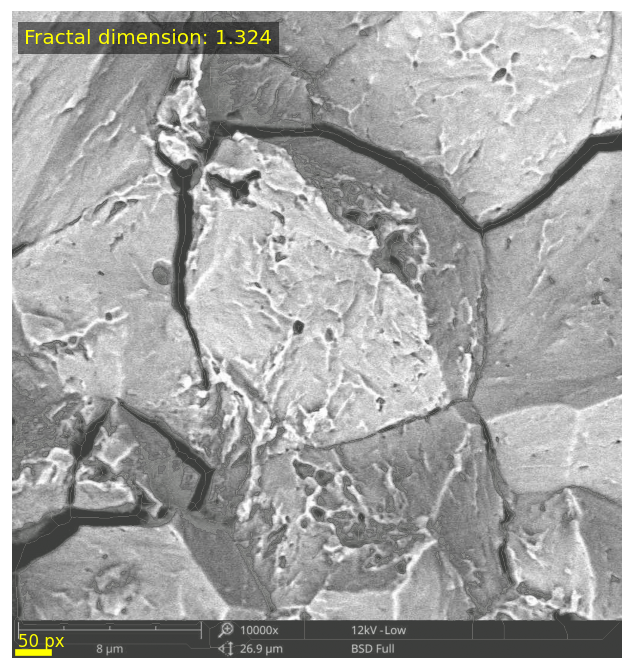

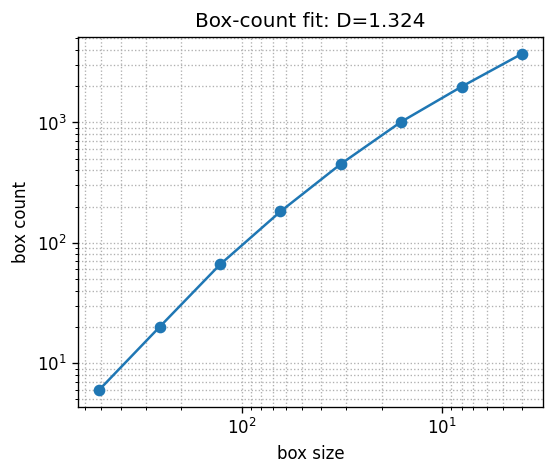

Processed: Fractured-bolt-intergranular-cleavage-e1535747902155.jpg → D=1.324


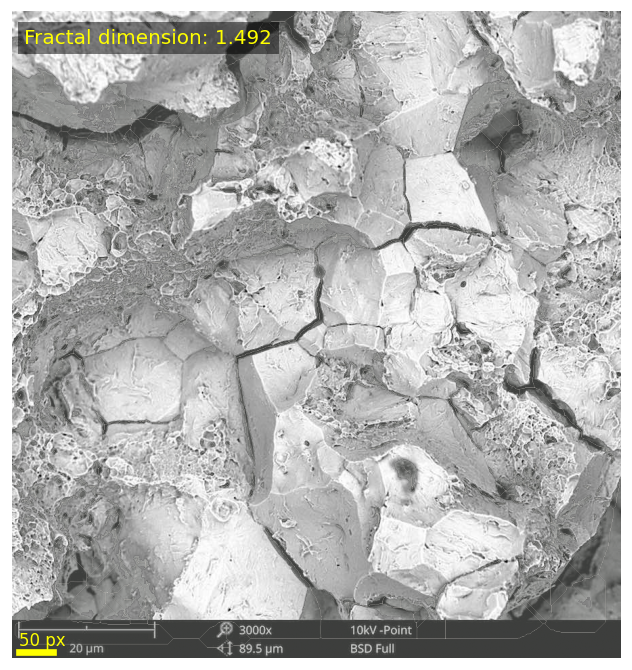

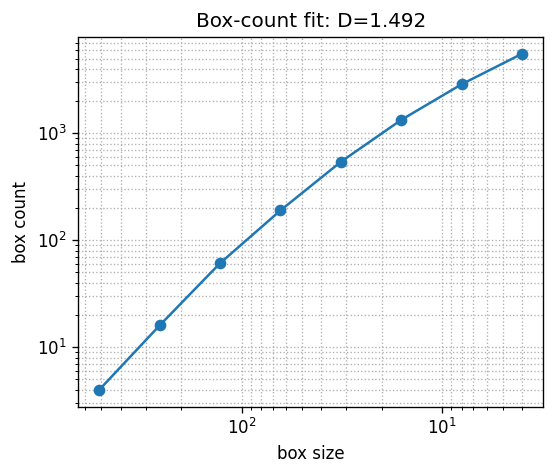

Processed: Fractured-bolt-low-res-integranular-cleavage.jpg → D=1.492

✅ Done! Results saved in: results


In [6]:
import glob
import pandas as pd

def process_folder(folder="fracture_images", out_dir="results", sigma=1.0, method='otsu', block=35):
    os.makedirs(out_dir, exist_ok=True)
    records = []

    for path in glob.glob(os.path.join(folder, "*")):
        try:
            # Load grayscale image
            img = io.imread(path, as_gray=True)
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)

            # Process and get fractal dimension
            D = process_image(img, sigma=sigma, method=method, block=block, scale_bar_px=50)

            # Save annotated figure
            fname = os.path.basename(path)
            out_path = os.path.join(out_dir, fname.replace(".", "_annotated."))
            plt.imsave(out_path, img, cmap='gray')

            # Store result
            records.append({"filename": fname, "fractal_dimension": D})
            print(f"Processed: {fname} → D={D:.3f}")

        except Exception as e:
            print(f"Error with {path}: {e}")

    # Save CSV
    df = pd.DataFrame(records)
    df.to_csv(os.path.join(out_dir, "fractal_results.csv"), index=False)
    print("\n✅ Done! Results saved in:", out_dir)
    return df

# Run on your folder
df_results = process_folder("fracture_images")
